In [3]:
!pip install gurobipy

### Imports utilizados:

In [1]:
import gurobipy as gp
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.stats import gmean

%matplotlib inline

from markowitz import Markowitz

### Leitura dos dados de entrada:

In [2]:
df = pd.read_excel('seriehistorica.xlsx', index_col = 0)
df.fillna(method='ffill',inplace=True)

pf = pd.read_excel('perfilfundos.xlsx', usecols = ['CNPJ', 'APLICACAO_MINIMA', 'CATEGORIA', 'SUBCATEGORIA'])
pf['CNPJ'] = pf['CNPJ'].str.replace('[./-]', '', regex=True)
pf['APLICACAO_MINIMA'] = pf['APLICACAO_MINIMA'].str.replace('-', '0').str.replace('R\$ ','').str.replace('.', '').astype(float)

pf.set_index('CNPJ',inplace=True)
pf.drop(index=(list(set(pf.index)-set(df.columns))),inplace=True)
pf.reset_index(inplace=True)

CNPJ_dict_tipos = dict()
for cat in pf.CATEGORIA.unique():
    CNPJ_dict_tipos[cat] = pf.query('CATEGORIA == @cat').index.to_list()

CNPJ_list = list(pf.CNPJ)
df = df[CNPJ_list]

pf.set_index('CNPJ',inplace=True)

### Parâmetros de entrada do modelo:

In [3]:
df_retorno = df.pct_change().dropna()
sigma = (df_retorno.cov()*252).to_numpy()
media = (df_retorno+1).apply(gmean)**252-1

In [4]:
valorMinFundos = np.array(pf['APLICACAO_MINIMA'])

In [5]:
minRetorno = 0.002
C = 100000
K_min = 3
K_max = 10
P_min = 0.05
P_max = 0.3

P_categorias = {
    'Ações': 0.25,
    'Cambial': 0.00,
    'Multimercados': 0.35,
    'Renda Fixa': 0.40
}

### Instanciando e resolvendo o modelo para minimização do risco com retorno mínimo pré-definido:

In [6]:
tempo_init = time.time()
modelo = Markowitz(C, CNPJ_list, CNPJ_dict_tipos, P_min, P_max, P_categorias, K_min, K_max, 
                   valorMinFundos, sigma, media, minRetorno)
print('Tempo para instanciar o modelo:', time.time() - tempo_init, 's')
carteira = modelo.solve(time = 30)
print('Fim do processo de solução')
print('Tempo total do processo:', time.time() - tempo_init, 's')

Academic license - for non-commercial use only - expires 2021-11-05
Using license file C:\Users\Eduardo\gurobi.lic
Tempo para instanciar o modelo: 6.053346395492554 s
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Fim do processo de solução
Tempo total do processo: 38.71321415901184 s


### Imprimindo resultados:

In [8]:
print('Resultado obtido:')

carteira.exibir(C)

print()
print('Categorias dos fundos escolhidos:')

categoria = np.array(pf['CATEGORIA'][carteira.CNPJ_list])
subcategoria = np.array(pf['SUBCATEGORIA'][carteira.CNPJ_list])

for i in range(len(categoria)):
    print(f"{carteira.CNPJ_list[i]} --> {categoria[i]} --> {subcategoria[i]}")


Resultado obtido:
Retorno esperado --> 5.53%
Risco estimado --> 1.66%
Fundo 76 (09720734000110) 	 Peso: 6.63% 	 Valor: R$ 6626.88
Fundo 154 (14799785000119) 	 Peso: 14.7% 	 Valor: R$ 14703.11
Fundo 193 (18558694000142) 	 Peso: 5.0% 	 Valor: R$ 5000.0
Fundo 257 (22232929000189) 	 Peso: 20.0% 	 Valor: R$ 20000.0
Fundo 260 (22407091000117) 	 Peso: 5.0% 	 Valor: R$ 5000.0
Fundo 299 (22003346000186) 	 Peso: 11.72% 	 Valor: R$ 11717.02
Fundo 417 (29319740000177) 	 Peso: 5.0% 	 Valor: R$ 5000.0
Fundo 437 (32102192000133) 	 Peso: 5.3% 	 Valor: R$ 5296.89
Fundo 450 (31923761000149) 	 Peso: 5.0% 	 Valor: R$ 5000.0
Fundo 470 (31963396000104) 	 Peso: 21.66% 	 Valor: R$ 21656.1

Categorias dos fundos escolhidos:
09720734000110 --> Renda Fixa --> Renda Fixa Duração Livre Grau de Investimento
14799785000119 --> Ações --> Ações Livre
18558694000142 --> Ações --> Ações Livre
22232929000189 --> Multimercados --> Multimercados Livre
22407091000117 --> Multimercados --> Multimercados Livre
22003346000186 

In [6]:
minRetorno = 0.0
tempo_init = time.time()
modelo = Markowitz(C, CNPJ_list, CNPJ_dict_tipos, P_min, P_max, P_categorias, K_min, K_max, 
                   valorMinFundos, sigma, media, minRetorno)
print('Tempo para instanciar o modelo:', time.time() - tempo_init, 's')
lista_GAP = list()

while(minRetorno < 0.1):
    print('minRetorno atual:', round(minRetorno, 5), end='\t')
    carteira = modelo.solve(time = 30)
    minRetorno += 0.01
    modelo.update_minRetorno(minRetorno)
    if(carteira.Retorno == 0):
        break
    else:
        lista_GAP.append(modelo.GAP)
print()        

print('Tempo total do processo:', time.time() - tempo_init, 's')

Academic license - for non-commercial use only - expires 2021-11-05
Using license file C:\Users\Eduardo\gurobi.lic
Tempo para instanciar o modelo: 6.064346790313721 s
minRetorno atual: 0.0	Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
minRetorno atual: 0.01	minRetorno atual: 0.02	minRetorno atual: 0.03	minRetorno atual: 0.04	minRetorno atual: 0.05	minRetorno atual: 0.06	minRetorno atual: 0.07	minRetorno atual: 0.08	minRetorno atual: 0.09	minRetorno atual: 0.1	
Tempo total do processo: 217.63444805145264 s


In [7]:
np.array(lista_GAP) * 100

array([2.46155275e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.86065684e-03, 0.00000000e+00,
       4.63649684e-01, 4.19046516e+00, 4.03647168e+00])

### Rodando o modelo sem limitar o retorno, mas utilizando a função objetivo original de Markowitz:

In [8]:
modelo = Markowitz(C, CNPJ_list, CNPJ_dict_tipos, P_min, P_max, P_categorias, K_min, K_max, 
                   valorMinFundos, sigma, media, obj_type='markowitz', l=50)
carteira = modelo.solve(time = 10)

carteira.exibir(C)


Changed value of parameter TimeLimit to 10.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Retorno esperado --> 46.6%
Risco estimado --> 6.06%
Fundo 160 (15188380000107) 	 Peso: 5.0% 	 Valor: R$ 5000.0
Fundo 248 (21732619000160) 	 Peso: 17.35% 	 Valor: R$ 17350.46
Fundo 331 (26664935000166) 	 Peso: 5.0% 	 Valor: R$ 5000.0
Fundo 381 (29177024000100) 	 Peso: 20.0% 	 Valor: R$ 20000.0
Fundo 419 (08968733000126) 	 Peso: 5.0% 	 Valor: R$ 5000.0
Fundo 435 (31964074000171) 	 Peso: 7.65% 	 Valor: R$ 7649.54
Fundo 444 (30934757000113) 	 Peso: 30.0% 	 Valor: R$ 30000.0
Fundo 505 (35088108000162) 	 Peso: 10.0% 	 Valor: R$ 10000.0


In [9]:
modelo.GAP * 100

0.009686989137228782

### Percentuais e tipos de fundos escolhidos:

In [43]:
import cufflinks as cf
from plotly.offline import plot, iplot
import plotly.express as px
import plotly.graph_objects as go

cf.go_offline()

pie_dados = list()

categoria = np.array(pf['CATEGORIA'][carteira.CNPJ_list])
subcategoria = np.array(pf['SUBCATEGORIA'][carteira.CNPJ_list])

for i in range(len(categoria)):
    pie_dados.append( [carteira.CNPJ_list[i], carteira.porcentagem[i], categoria[i]])

pie_dados = pd.DataFrame(pie_dados, columns = ['CNPJ', 'porcentagem', 'Tipo'])
pie_dados
#pie_dados.iplot(kind='pie', values='porcentagem', labels='Tipo', colorscale='plotly', title='CARTEIRA 1')
#pie_dados.iplot(kind='pie', values='porcentagem', labels='Tipo', colorscale='plotly', title='CARTEIRA 1', asImage=True)

fig = px.pie(pie_dados, values='porcentagem', names='Tipo', title='CARTEIRA 1')
fig.update_traces(textposition='inside', textfont_size=22, textfont_color='white')
fig.show()

### Para gerar um conjunto de pontos da Fronteira Eficiente igualmente espaçados sobre o retorno mínimo esperado:

In [17]:
modelo = Markowitz(C, CNPJ_list, CNPJ_dict_tipos, P_min, P_max, P_categorias, K_min, K_max, 
                   valorMinFundos, sigma, media)

In [18]:
carteiras, idx_max_sharpe = modelo.solve_fronteira(0.0, 0.5, 0.03, print_steps=True)

minRetorno atual: 0.0
Changed value of parameter TimeLimit to 15.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
minRetorno atual: 0.03
minRetorno atual: 0.06
minRetorno atual: 0.09
minRetorno atual: 0.12
minRetorno atual: 0.15
minRetorno atual: 0.18
minRetorno atual: 0.21
minRetorno atual: 0.24
minRetorno atual: 0.27
minRetorno atual: 0.30000000000000004
minRetorno atual: 0.33000000000000007
minRetorno atual: 0.3600000000000001
minRetorno atual: 0.3900000000000001
minRetorno atual: 0.42000000000000015
minRetorno atual: 0.4500000000000002
minRetorno atual: 0.4800000000000002


In [19]:
carteiras

[Carteira(Retorno=0.06066188721235282, Risco=0.01057550627456946, Qtd. de fundos=10,
 fundos=[154, 257, 272, 299, 346, 354, 417, 437, 444, 470], 
 porcentagem=[0.0999999999999999, 0.1029205367892107, 0.06036942231641867, 0.1350876897603441, 0.19707946321078929, 0.09573112529288473, 0.05, 0.05, 0.05239351615692341, 0.15641824647342908], 
 CNPJ_list=['14799785000119', '22232929000189', '20584638000124', '22003346000186', '26841302000186', '27826059000190', '29319740000177', '32102192000133', '30934757000113', '31963396000104'], 
 valorMinFundos=[5000.0, 5000.0, 1000.0, 100.0, 10000.0, 500.0, 1000.0, 5000.0, 1000.0, 100.0],
 Carteira(Retorno=0.060661887212352814, Risco=0.010575506274569465, Qtd. de fundos=10,
 fundos=[154, 257, 272, 299, 346, 354, 417, 437, 444, 470], 
 porcentagem=[0.1000000000000002, 0.10292053678921105, 0.06036942231641885, 0.13508768976034377, 0.19707946321078912, 0.0957311252928845, 0.04999999999999982, 0.04999999999999982, 0.05239351615692337, 0.15641824647342956], 

### Calculando os valores de Sharpe das soluções obtidas:

In [20]:
for cart in carteiras:
    print( (cart.Retorno - 0.0525)/cart.Risco )

0.7717727171113709
0.7717727171113697
0.7717727171113697
3.4368245617772706
5.373682993478341
6.7581691604504055
7.2228158043233135
7.411729069767013
7.381091882848981
7.498889929701102
7.458047321245698
7.293186383837344
7.180091303672742
7.089294774787873
6.815737896503788
6.814756082298708
6.710690783168285


### Plot da Fronteira Eficiente construída:

<Figure size 432x288 with 0 Axes>

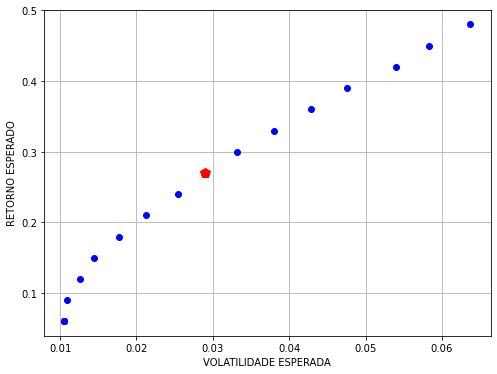

In [21]:
fig = plt.figure() 
plt.figure(figsize=(8,6))
plt.plot([cart.Risco for cart in carteiras], [cart.Retorno for cart in carteiras], 'ob')
plt.plot(carteiras[idx_max_sharpe].Risco, carteiras[idx_max_sharpe].Retorno, 'pr', markersize='11')
#plt.ylim((0,1.25))
#plt.xlim((-0.01,0.7))
plt.grid()
plt.xlabel('VOLATILIDADE ESPERADA')
plt.ylabel('RETORNO ESPERADO')
#plt.savefig('conservador.pdf')
plt.show()

### Olhando com mais detalhes para a solução construída:

`Vamos padronizar os dados utilizando escores-Z para os dados poderem ser colocados em uma mesma imagem`

In [44]:
import cufflinks as cf
from plotly.offline import plot, iplot

cf.go_offline()

series_temp = df.loc[:, carteira.CNPJ_list]
series_temp = (series_temp - series_temp.mean())/series_temp.std()

series_temp.iplot()

<AxesSubplot:title={'center':'Soma dos Escores Z das Séries'}>

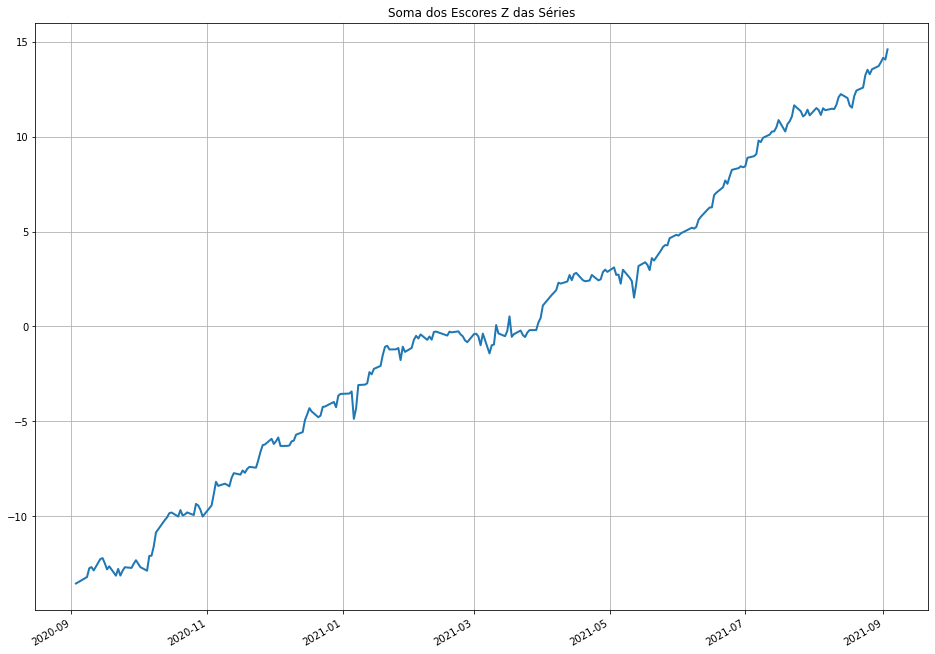

In [47]:
series_temp.sum(axis=1).plot(figsize=(16, 12), title='Soma dos Escores Z das Séries', grid=True, linewidth=2.0)

### Fronteira Eficiente no Plotly:

In [24]:
import cufflinks as cf
from plotly.offline import plot, iplot
import plotly.express as px
import plotly.graph_objects as go

cf.go_offline()

taxa_livre_de_risco = 0.0525

a_risco = [cart.Risco for cart in carteiras]
a_retorno = [cart.Retorno for cart in carteiras]
a_sharpe = [ (cart.Retorno - taxa_livre_de_risco)/cart.Risco for cart in carteiras  ]

dados = pd.DataFrame([a_risco, a_retorno, a_sharpe]).T

dados.columns = ['VOLATILIDADE ESPERADA', 'RETORNO ESPERADO', 'SHARPE']
dados['Opt'] = ['No'] * len(a_risco)
dados['Opt'][idx_max_sharpe] = 'Yes'


In [25]:
fig = px.scatter(dados, x='VOLATILIDADE ESPERADA', y='RETORNO ESPERADO', color='SHARPE')

#fig.add_trace(go.Scatter(x = [a_risco[idx_max_sharpe]], y = [a_retorno[idx_max_sharpe]], mode='markers', 
#    marker_color='rgb(255, 0, 0)', showlegend=False, name=f'Sharpe: {a_sharpe[idx_max_sharpe]}'))

fig.update_traces(marker_size = 12)

fig.show()